# MONAI Optimisations for JADE
## 

### Eric Kerfoot, King's College London, eric.kerfoot@kcl.ac.uk
### MONAI Developers, https://monai.io

### How to Optimise Workflow
* What components should be considered for the platform we're on?
  * Loading data efficiently
  * Transforming data quickly
  * Perform network training quickly
  * Saving results efficiently
* Many elements (model, loss function, training process) are independent factors
* Data probably should be preprocessed for optimised loading during training

We'll make our test dataset:

In [3]:
import tempfile
import nibabel as nib
import numpy as np
from monai.data import create_test_image_3d

fn_keys = ("image", "label")  # filename keys for image and seg files
root_dir = tempfile.mkdtemp()
filenames = []

for i in range(100):
    im, seg = create_test_image_3d(128, 128, 128, num_objs=6, num_seg_classes=2, rad_max=30)
    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"image": im_filename, "label": seg_filename})
    nib.save(nib.Nifti1Image(im, np.eye(4)), im_filename)
    nib.save(nib.Nifti1Image(seg, np.eye(4)), seg_filename)

### Dataset Caching

* MONAI provides `Dataset` classes to implement different forms of caching
* This relies on running deterministic transforms once and then during training only using randomised transforms
* The simplest is `CacheDataset` which loads data entirely into memory by applying the first deterministic transforms to each data item given to it
* When items are requested, any further transforms are applied.

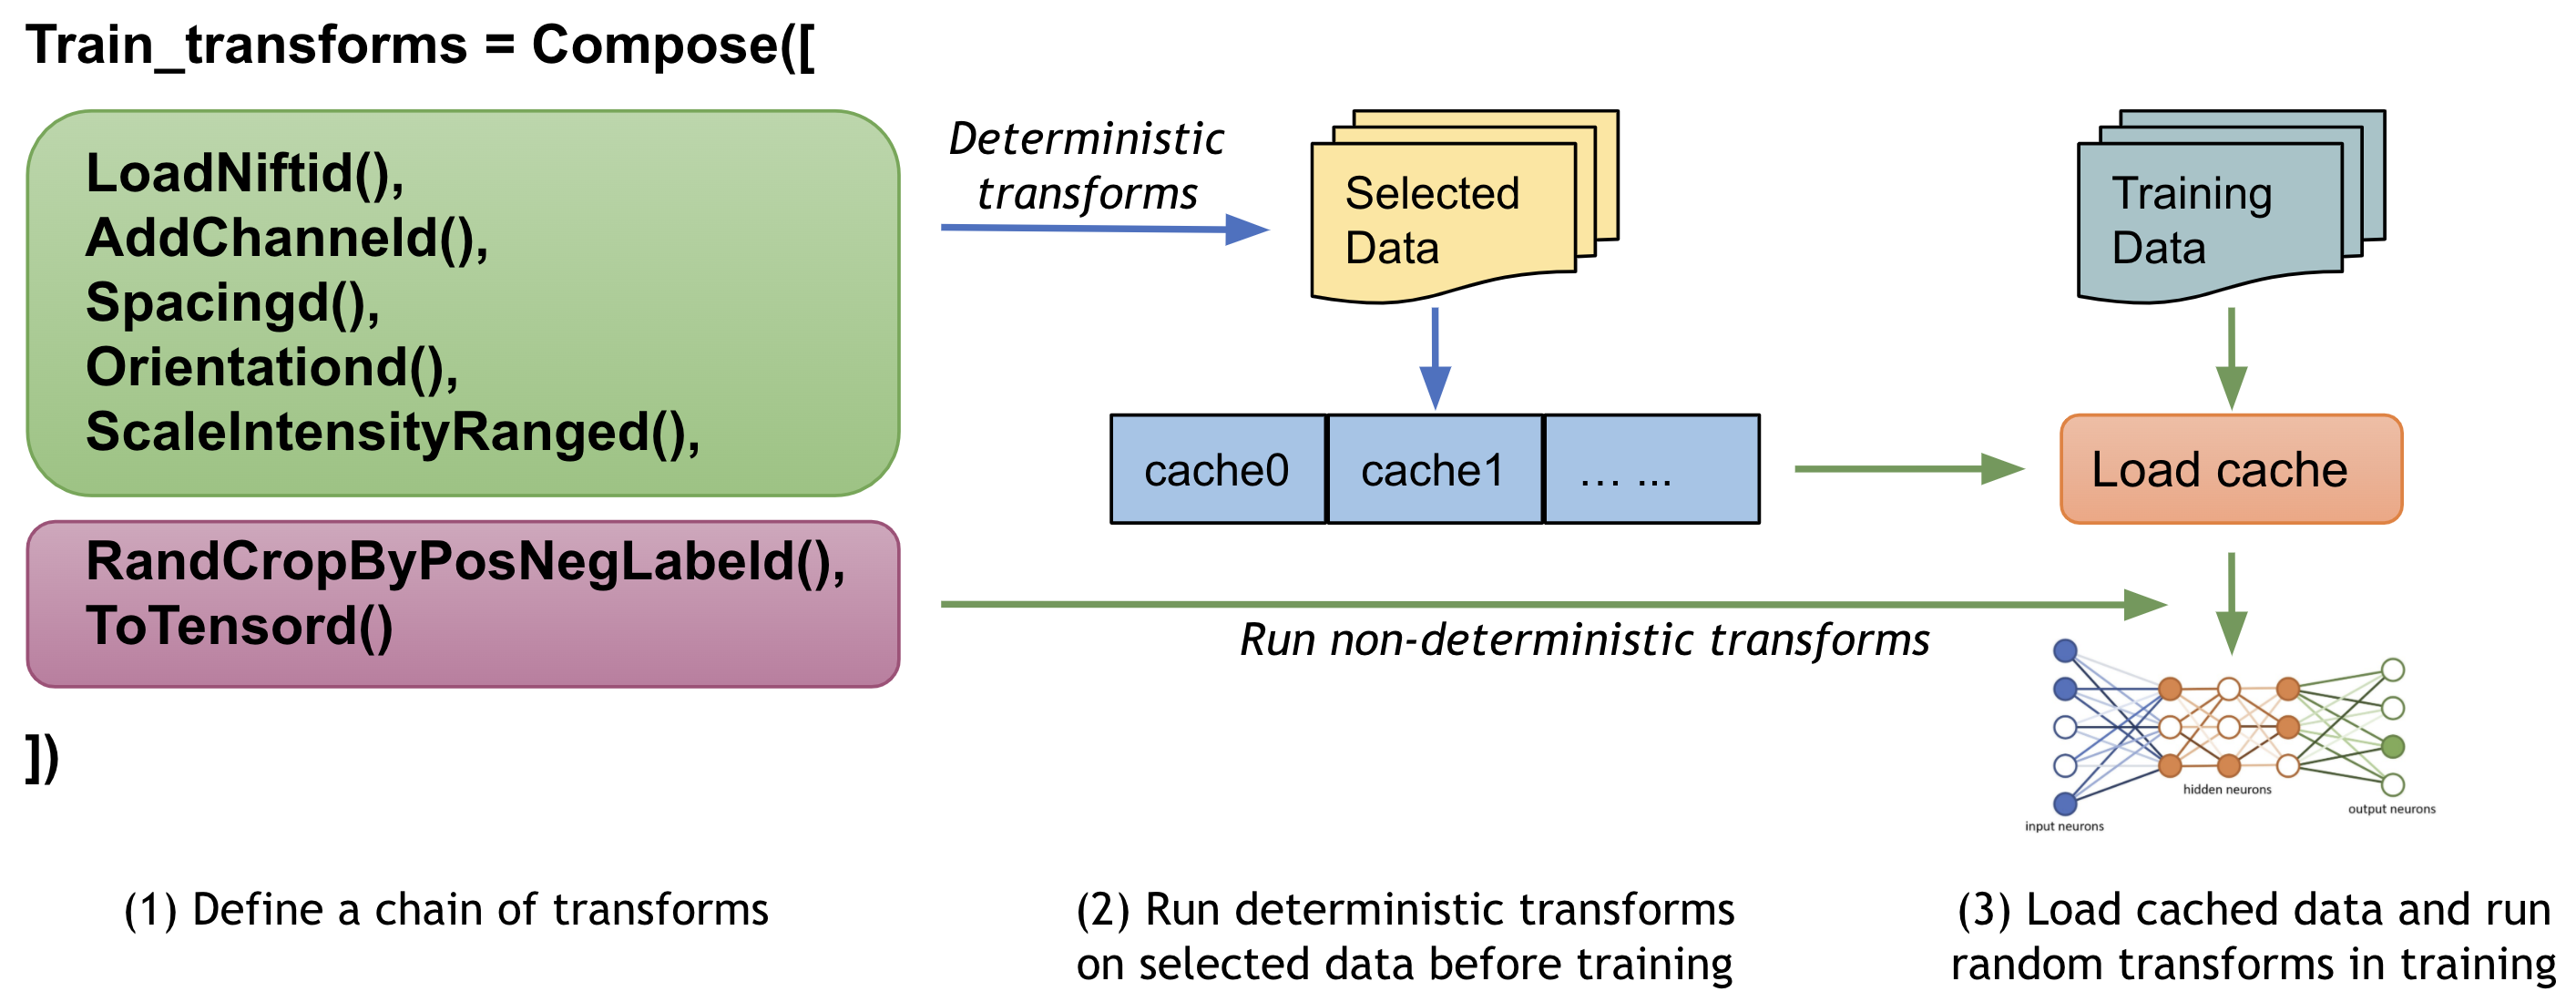

In [7]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd
trans=Compose([
    LoadImaged(keys=fn_keys),
    EnsureChannelFirstd(keys=fn_keys),
    ScaleIntensityd(keys=fn_keys)
])

ds = CacheDataset(filenames, transform=trans)

dl = DataLoader(ds, num_workers=8)

%time all_items=list(dl)

Loading dataset: 100%|██████████| 100/100 [00:03<00:00, 25.96it/s]


CPU times: user 199 ms, sys: 578 ms, total: 777 ms
Wall time: 1.29 s


* Other types of caching:
  * `PersistentDataset` stores results to files and loads these on request
  * `SmartCacheDataset` loads a subset of the dataset for any one epoch and then loads further data after an epoch finishes, meant to ensure a continual stream of data is available
  * `LMDBDataset` uses a LMDB database as a backend
* Key concept is to have preprocessing transforms first, followed by randomised data augmentations
* Caching uses transform types to decide what is deterministic

* We'll get to using these components later in the practical half
* How do these interact with the scratch disk? How should that be used to optimise performance?
* Important to consider how to put a pipeline of transforms together to do the data processing you need
  * If inputs are being resized/cropped/padded this should be done early to make computation quicker and memory footprint smaller
  * Combining transforms into one if possible 
  * All preprocessing done before first random augmentations, your transform pipeline won't be cached after this

* Eg. in the group exercise, data is read and padded:
```python
pad_size = (256, 256, 160)

train_transforms = Compose([
    LoadImage(),
    Lambda(_rearrange_images),
    ScaleIntensityd(keys,channel_wise=True),
    SpatialPadd(keys, spatial_size=pad_size)
])
```
* This is making data larger, should be done after augmentations?

* Something like this has different implications:
```python
train_transforms = Compose([
    LoadImage(),
    Lambda(_rearrange_images),
    ScaleIntensityd(keys,channel_wise=True),
    RandFlipd(keys,prob=0.5, spatial_axis=0),
    # other augmentations here
    SpatialPadd(keys, spatial_size=pad_size)
])
```
* Data just before `RandFlipd` would be stored in a `CacheDataset`, `SpatialPadd` would always be run as well so is that too slow?

* Need to consider which `Dataset` class makes sense
  * How many workers is important, shouldn't be so many it hits storage too hard, remember `-c` SLURM flag
* Transform order and how many is important, too many expensive resamples (eg. `RandAffined`) slows training a lot
* Preprocessing data beforehand, in scripts using transforms, can be used to reduce amount loaded during training
* Many transforms can operate on GPU memory, use `ToTensord` to convert, and `torch.multiprocessing.set_start_method("spawn")` may be needed

### Transforms

* Critical component to data handling in MONAI
* Used for processing data to create batches, postprocess outputs from networks
* Many transforms are provided for data augmentation, this is important for generating more diversity in your data
* One major issue is choosing what transforms are a good runtime tradeoff

* Many transforms together can be very slow
* Eg. `RandAffine` or `Rand3DElastic` will perform resampling of the whole input volumes
* This is expensive, so choosing how many of these to have is an important consideration
* If time taken to generate a batch outweighs training time you get very poor GPU utilisation

## ThreadDataLoader

* Depending on what transforms you use, this could be faster
* Also generates next batch in separate thread
* Issue is the GIL, anything using compiled code can release this lock so threads could be fast
* Using CUDA in multiple processes sometimes is difficult (hence why to set the start method) so threads may make sense
* Also can be used to avoid weird behaviour under Windows
* Class can also yield the same batch multiple times to allow more training while next batch is generated

### Bundles and Scripts

* As mentioned earlier, bundles use JSON/YAML script definitions to create training or inference programs
* These contain many parameters and definitions which can be changed on the command line
* This can be used with SLURM to launch multiple jobs with different parameters
* Useful for doing parameter sweeps or other experiments

* Consider this example
```bash
$HOME/miniconda3/envs/monai/bin/python \
    -m monai.bundle run training \
    --meta_file "$BUNDLE/configs/metadata.json" \
    --config_file "$BUNDLE/configs/train.json" \
    --bundle_root "$BUNDLE" \
    --dataset_dir "$DATASETDIR" \
    --some_obj::param 42 \
```
* the value for `some_obj.param` is fixed, but could instead be a bash variable

```bash
$HOME/miniconda3/envs/monai/bin/python \
...
    --some_obj::param "${PARAM}" \
```

* SLURM's `sbatch` has a `--export` argument to export a series of variables in the job's environment
* `sbatch --export=PARAM=100 job.sh` will set the value passed to the bundle
* Running `sbatch` with different values for `PARAM` will queue multiple runs up with different settings
* Can be used for setting training rate, probabilities for augmentations, data directories, etc.

### Many Other Optimisations
* Many more things could be done to optimise code unrelated to HPC coding:
* Using Automatic Mixed Precision, which is just a flag with workflow classes
* TensorRT (https://github.com/Project-MONAI/tutorials/blob/main/acceleration/TensorRT_inference_acceleration.ipynb)
* Using Cupy/CuCIM to push more computation to GPU
* Profiling your code to find bottlenecks
* See https://github.com/Project-MONAI/tutorials/blob/main/acceleration/fast_model_training_guide.md

### Next: Group Activity

* Divide into groups so that everyone is with someone with a JADE account ready to go
* Go through the next notebook as far as you can, you won't finish today
* Explore using these concepts to speed up the training process, so develop a way to profile your code and measure how long iterations take